In [5]:
!pip install tensorflow

In [9]:
!pip install --user matplotlib

In [10]:
!pip install segmentation_models_pytorch

In [21]:
!pip install sklearn

     |████████████████████████████████| 26.7 MB 15.5 MB/s eta 0:00:01   |█████████▏                      | 7.6 MB 2.6 MB/s eta 0:00:08
     |████████████████████████████████| 306 kB 40.9 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=a654f8f9c70e106ed9bf698b10718bdd470cb49c3cdc9a2f40f9d76f0015914e
  Stored in directory: /misc/home4/s0011/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [107]:
import os

import tensorflow as tf
from tensorflow import keras
import torch
import sys

In [113]:
!ls 220308_23_52_b6_unet32_s2_tc_fp16/main/checkpoints_optimized_jaccard

best.pth  _metrics.json


In [114]:
!cat 220308_23_52_b6_unet32_s2_tc_fp16/main/checkpoints_optimized_jaccard/_metrics.json

{
  "best": {
    "optimized_jaccard/threshold": 0.3499999940395355,
    "optimized_jaccard": 0.7194233303445352,
    "accuracy": 0.96367274017334,
    "pred_mask/bce": 0.1041667981896549,
    "pred_mask/dice": 0.28283835844993616,
    "loss": 0.38700515854060674
  },
  "last": {
    "optimized_jaccard/threshold": 0.30000001192092896,
    "optimized_jaccard": 0.47853889772844743,
    "accuracy": 0.9130987091064456,
    "pred_mask/bce": NaN,
    "pred_mask/dice": NaN,
    "loss": NaN
  },
  "train.6": {
    "optimized_jaccard/threshold": 0.3499999940395355,
    "optimized_jaccard": 0.7194233303445352,
    "accuracy": 0.96367274017334,
    "pred_mask/bce": 0.1041667981896549,
    "pred_mask/dice": 0.28283835844993616,
    "loss": 0.38700515854060674
  },
  "train.4": {
    "optimized_jaccard/threshold": 0.32499998807907104,
    "optimized_jaccard": 0.7073660116160234,
    "accuracy": 0.9615985885620115,
    "pred_mask/bce": 0.11052386885955934,
    "pred_mask/dice": 0.3171544549465179,
 

In [104]:
model_dict = torch.load('220308_23_52_b6_unet32_s2_tc_fp16/main/checkpoints/best.pth', 
           map_location=torch.device('cpu')
          )

In [116]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /home/s0011/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /home/s0011/.cache/torch/hub/checkpoints/unet-e012d006.pt


In [118]:
model

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [105]:
torch.cuda.is_available()

False

In [3]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [4]:
import os
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

In [72]:
!ls ~/data_inria/train/gt/austin10.tif

/home/s0011/data_inria/train/gt/austin10.tif


In [5]:
gt_path = '/home/s0011/data_inria/train/gt/austin10.tif'
im_path = '/home/s0011/data_inria/train/images/austin10.tif'

In [6]:
from PIL import Image
from torchvision.transforms import ToTensor

def open_to_tensor(path):
    image = Image.open(path)
    w, h = image.size
    print(w, h)
    k = 32
    w -= w % k
    h -= h % k
    size = (0, 0, w, h)
    image = image.crop(size)
    image = ToTensor()(image)
    image = torch.unsqueeze(image, 0)
    print(image.shape)
    return image

open_to_tensor(im_path).shape

5000 5000
torch.Size([1, 3, 4992, 4992])


torch.Size([1, 3, 4992, 4992])

In [8]:
image = open_to_tensor(im_path)
# image = torch.rand([1, 3, 32*k, 32*k])

5000 5000
torch.Size([1, 3, 4992, 4992])


In [127]:
gt_mask = open_to_tensor(gt_path)

5000 5000
torch.Size([1, 1, 4992, 4992])


In [119]:
with torch.no_grad():
#     opp,_,_ = m(vec)
    logits = model(image)
    mask = logits.sigmoid()

[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.


In [142]:
def plot_im(im):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(
        im, 
        cmap='gray'
    )
    plt.show()

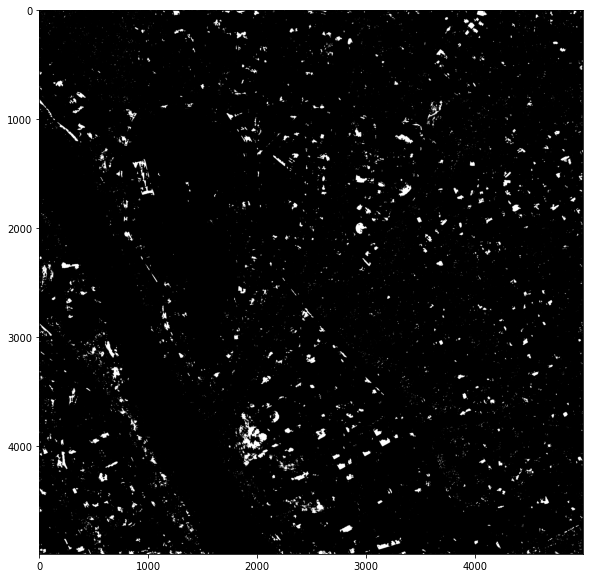

In [143]:
mask_p = mask.permute(3,2,1,0).detach().numpy().squeeze()
plot_im(mask_p)

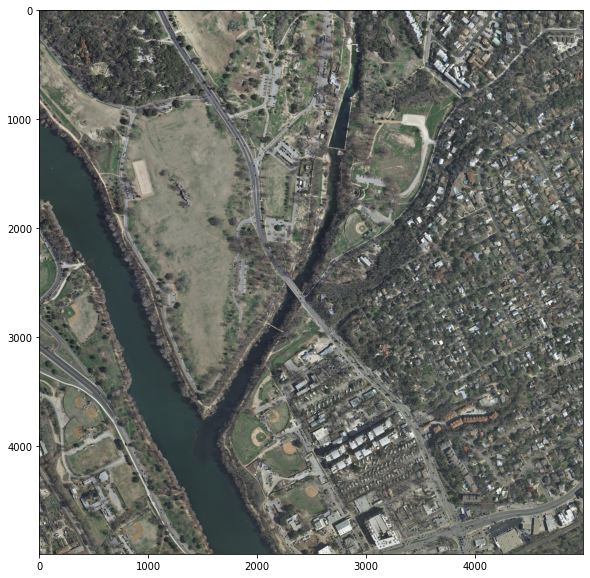

In [144]:
im = image.permute(3,2,1,0).squeeze()
plot_im(im)

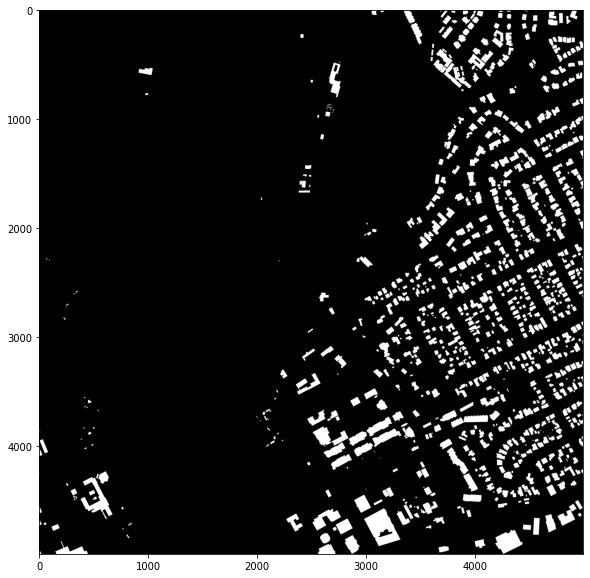

In [145]:
gt = gt_mask.permute(3,2,1,0).squeeze()
plot_im(gt)

In [96]:
SMOOTH = 1e-6
def iou(pred, gt):
    
    b, c, w, h = gt.size()
    intersection = pred.logical_and(gt)
    union = pred.logical_or(gt)
    iou = (intersection + SMOOTH) / (union + SMOOTH) 
    return iou.sum()/(w*h)

In [148]:
float(iou(mask, gt_mask))

0.07934620976448059

In [156]:
def plot_lineup(im, gt):
    fig, ax = plt.subplots(figsize = (20,20))

    img = ax.imshow(im, interpolation='nearest', origin='lower')
    img = ax.imshow(gt, 
                    interpolation='nearest', 
                    alpha=0.5, 
                    origin='lower',
                    cmap='gray',
                   )


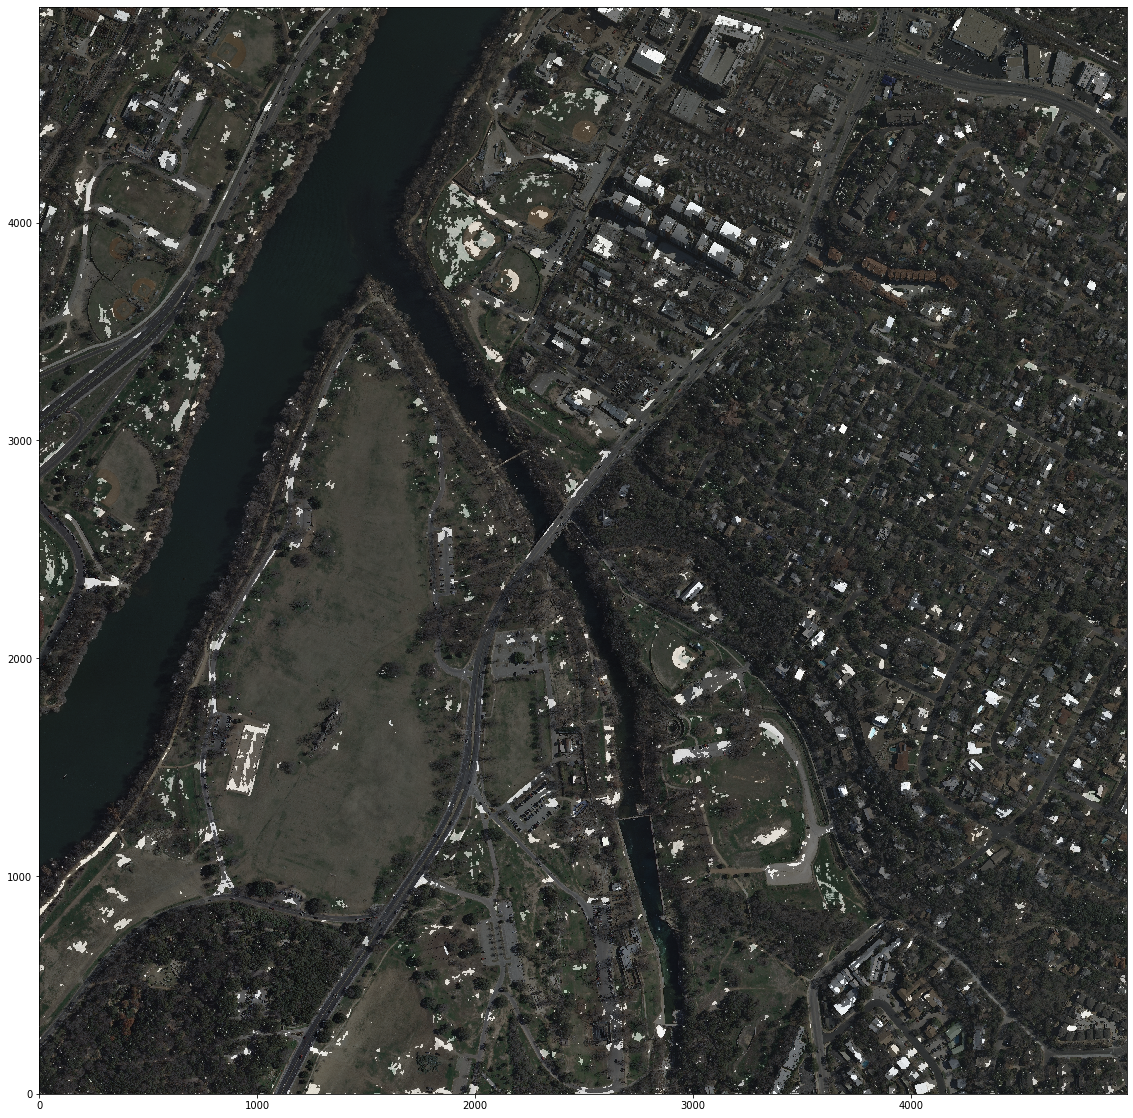

In [159]:
plot_lineup(im, mask_p)

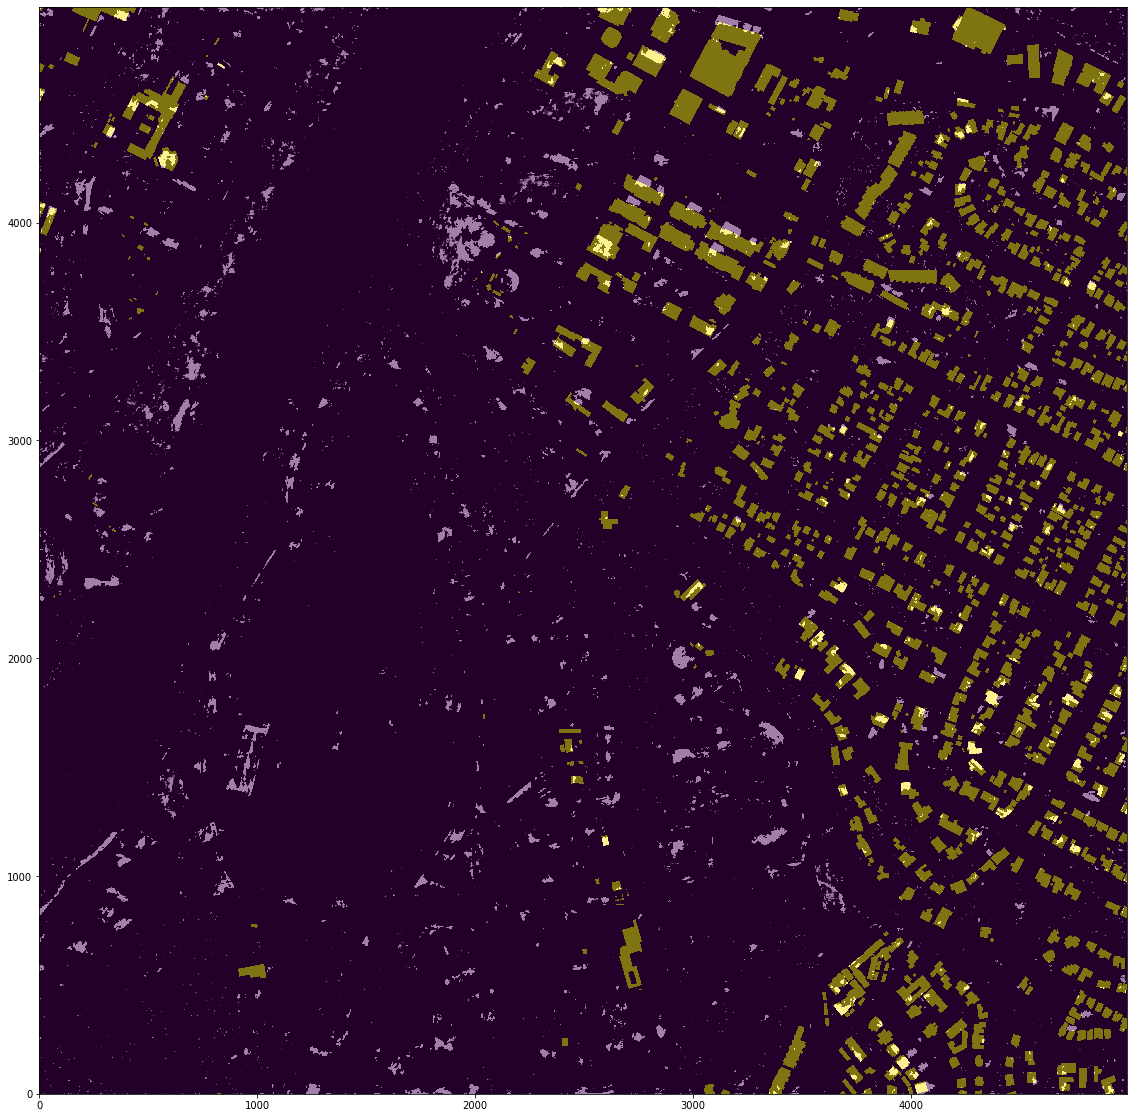

In [161]:
plot_lineup(gt, mask_p)

In [166]:
!git clone git@github.com:gerberka/catalyst-inria.git


Cloning into 'catalyst-inria'...
remote: Enumerating objects: 1341, done.
remote: Counting objects: 100% (1341/1341), done.
remote: Compressing objects: 100% (379/379), done.
remote: Total 1341 (delta 958), reused 1341 (delta 958), pack-reused 0
Receiving objects: 100% (1341/1341), 1.63 MiB | 2.85 MiB/s, done.
Resolving deltas: 100% (958/958), done.
Updating files: 100% (50/50), done.


In [1]:
def get_model(model_name: str, pretrained=True, **kwargs):
    from catalyst.dl import registry

    model_fn = registry.MODEL.get(model_name)
    return model_fn(pretrained=pretrained, **kwargs)

In [3]:
get_model("b6_unet32_s2")

ImportError: cannot import name 'registry' from 'catalyst.dl' (/home/s0011/miniconda3/lib/python3.8/site-packages/catalyst/dl/__init__.py)

In [6]:
import catalyst


In [9]:
dir(catalyst.dl)

AttributeError: module 'catalyst' has no attribute 'catalyst'

In [ ]:

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)